# **DonorsChoose Data Set**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from collections import Counter

# 1.Reading Data

In [3]:
project_data = pd.read_csv('/content/drive/MyDrive/Copy of train_data.csv',nrows=50000)
resource_data = pd.read_csv('/content/drive/MyDrive/Copy of resources.csv')

# Features to be considered - 
#  project_grade_category
#  teacher_prefix
#  project_title
#  school_state
#  essay
#  project_subject_category
#  project_subject_sub_category
#  price
#  teacher_number_of_previously_posted_projects


In [4]:
print("Number of data points in train data",project_data.shape)
print('-'*50)
print("The attributes of data are - ",project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data are -  ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


##  preprocessing of `project_grade_category` - Categorical feature

In [6]:
print(project_data['project_grade_category'].value_counts())

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64


In [7]:
# As a part of pre-processing we need to replace space with '_' and '-' with '_'. Also convert all the letters to lower case

In [8]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    20316
grades_3_5       16968
grades_6_8        7750
grades_9_12       4966
Name: project_grade_category, dtype: int64

# Preprocessing Categorical Features: project_subject_categories



In [9]:
print(project_data['project_subject_categories'].value_counts())

Literacy & Language                           10927
Math & Science                                 7695
Literacy & Language, Math & Science            6705
Health & Sports                                4700
Music & The Arts                               2358
Special Needs                                  1913
Literacy & Language, Special Needs             1814
Applied Learning                               1719
Math & Science, Literacy & Language            1041
Applied Learning, Literacy & Language          1018
Math & Science, Special Needs                   871
History & Civics                                839
Literacy & Language, Music & The Arts           794
Math & Science, Music & The Arts                755
Applied Learning, Special Needs                 672
History & Civics, Literacy & Language           651
Health & Sports, Special Needs                  633
Warmth, Care & Hunger                           606
Math & Science, Applied Learning                565
Applied Lear

In [10]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       10927
math_science                             7695
literacy_language_math_science           6705
health_sports                            4700
music_arts                               2358
specialneeds                             1913
literacy_language_specialneeds           1814
appliedlearning                          1719
math_science_literacy_language           1041
appliedlearning_literacy_language        1018
math_science_specialneeds                 871
history_civics                            839
literacy_language_music_arts              794
math_science_music_arts                   755
appliedlearning_specialneeds              672
history_civics_literacy_language          651
health_sports_specialneeds                633
warmth_care_hunger                        606
math_science_appliedlearning              565
appliedlearning_math_science              477
health_sports_literacy_language           369
literacy_language_history_civics  

# Preprocessing Categorical Features: teacher_prefix

In [11]:
print(project_data['teacher_prefix'].value_counts())

Mrs.       26140
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64


In [12]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')

In [13]:
print(project_data['teacher_prefix'].value_counts())

Mrs.       26142
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64


In [14]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        26142
ms         17936
mr          4859
teacher     1061
dr             2
Name: teacher_prefix, dtype: int64

#  Preprocessing Categorical Features: project_subject_subcategories

In [15]:
print(project_data['project_subject_subcategories'].value_counts())

Literacy                                   4434
Literacy, Mathematics                      3833
Literature & Writing, Mathematics          2705
Literacy, Literature & Writing             2570
Mathematics                                2441
                                           ... 
College & Career Prep, Gym & Fitness          1
Character Education, Financial Literacy       1
Gym & Fitness, Social Sciences                1
Parent Involvement, Team Sports               1
Financial Literacy, Parent Involvement        1
Name: project_subject_subcategories, Length: 384, dtype: int64


In [16]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                4434
literacy_mathematics                    3833
literature_writing_mathematics          2705
literacy_literature_writing             2570
mathematics                             2441
                                        ... 
college_careerprep_gym_fitness             1
charactereducation_financialliteracy       1
gym_fitness_socialsciences                 1
parentinvolvement_teamsports               1
financialliteracy_parentinvolvement        1
Name: project_subject_subcategories, Length: 384, dtype: int64

#  Preprocessing Categorical Features: school_state

In [17]:
print(project_data['school_state'].value_counts())

CA    7024
NY    3393
TX    3320
FL    2839
NC    2340
IL    1967
SC    1830
GA    1828
MI    1468
PA    1419
OH    1180
IN    1171
MO    1166
WA    1103
LA    1094
MA    1076
OK    1074
NJ    1005
AZ     994
VA     916
WI     833
UT     792
AL     790
TN     774
CT     774
MD     668
NV     665
KY     614
MS     598
OR     577
MN     556
CO     538
AR     446
IA     306
ID     302
KS     285
DC     247
HI     239
NM     236
ME     222
WV     218
DE     155
AK     153
NE     144
SD     142
NH     141
RI     126
MT     106
ND      63
WY      51
VT      32
Name: school_state, dtype: int64


In [18]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    7024
ny    3393
tx    3320
fl    2839
nc    2340
il    1967
sc    1830
ga    1828
mi    1468
pa    1419
oh    1180
in    1171
mo    1166
wa    1103
la    1094
ma    1076
ok    1074
nj    1005
az     994
va     916
wi     833
ut     792
al     790
tn     774
ct     774
md     668
nv     665
ky     614
ms     598
or     577
mn     556
co     538
ar     446
ia     306
id     302
ks     285
dc     247
hi     239
nm     236
me     222
wv     218
de     155
ak     153
ne     144
sd     142
nh     141
ri     126
mt     106
nd      63
wy      51
vt      32
Name: school_state, dtype: int64

#  Preprocessing Categorical Features: project_title

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [21]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [22]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [23]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [24]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 50000/50000 [00:01<00:00, 32982.95it/s]


In [25]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


In [26]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)


#  Preprocessing Categorical Features: essay

In [27]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [28]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [29]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 50000/50000 [00:35<00:00, 1397.01it/s]


In [30]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

In [31]:
#creating a new column with the preprocessed essays and replacing it with the original columns
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

<h2>Calculate sentiment score in essay

In [32]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

neg_score = []
pos_score = []
neu_score = []
compound_score = []

for essay in tqdm(project_data["preprocessed_essays"]) :
  neg_score.append(analyser.polarity_scores(essay)['neg'])
  pos_score.append(analyser.polarity_scores(essay)['pos'])
  neu_score.append(analyser.polarity_scores(essay)['neu'])
  compound_score.append(analyser.polarity_scores(essay)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


100%|██████████| 50000/50000 [05:59<00:00, 139.03it/s]


In [33]:
project_data['neg_score'] = neg_score
project_data['pos_score'] = pos_score
project_data['neu_score'] = neu_score
project_data['compound_score'] = compound_score

In [34]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [35]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [36]:
# Drop Table project_is_approved
y = project_data['project_is_approved'].values
X = project_data.drop(['Unnamed: 0','teacher_id','project_submitted_datetime','id','essay','project_resource_summary','quantity'],axis=1)

# Step 1 - Split the data into train and test using stratified sampling

In [37]:
# Split data into Train and Test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.33)

print("train dataset = ", len(X_train)/len(project_data) * 100,"%")
print(X_train.shape[0])
print("test dataset = ", len(X_test)/len(project_data) * 100,"%")
print(X_test.shape[0])

train dataset =  67.0 %
33500
test dataset =  33.0 %
16500


# Step 2 - Vectorizing Categorical Data ( Response Encoding )

In [38]:
import pdb
def get_dict_for_feature_values(alpha,feature,df):
  #pdb.set_trace()
  value_counts = X_train[feature].value_counts()
  encoding_dict = {}

  for feature_val,count in value_counts.items():
    vec = []
    for k in range(2):
      #find all the data points where df[feature] = feature_val & df['project_is_approved'] == k
      data_cnt = df.loc[(df[feature] == feature_val) & (df['project_is_approved'] == k)]
      vec.append((data_cnt.shape[0] + alpha*10)/ (count + 20*alpha))

    encoding_dict[feature_val] = vec

  return encoding_dict  

In [39]:
def get_response_encoded_values(alpha,feature,df):
  output_fea = []
  encoding_dict = get_dict_for_feature_values(alpha,feature,df)
  value_count = X_train[feature].value_counts()
  #pdb.set_trace()
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      output_fea.append(encoding_dict[row[feature]])
    else:
      output_fea.append([1/2,1/2])  
  return output_fea    

In [40]:
# Vectorizing Categorical Data

# 1. School_state

alpha = 1
train_school_state_one_hot = np.array(get_response_encoded_values(alpha, "school_state", X_train))
test_school_state_one_hot = np.array(get_response_encoded_values(alpha, "school_state", X_test))

print(train_school_state_one_hot.shape)
print(test_school_state_one_hot.shape)

(33500, 2)
(16500, 2)


In [41]:
# 2.Project Subject categories

alpha = 1
train_project_subject_categories_one_hot = np.array(get_response_encoded_values(alpha, "project_subject_categories", X_train))
test_project_subject_categories_one_hot =np.array(get_response_encoded_values(alpha, "project_subject_categories", X_test))

print(train_project_subject_categories_one_hot.shape)
print(test_project_subject_categories_one_hot.shape)

(33500, 2)
(16500, 2)


In [42]:
# 3.Project Subject sub-categories

alpha = 1
train_project_subject_subcategories_one_hot = np.array(get_response_encoded_values(alpha, "project_subject_subcategories", X_train))
test_project_subject_subcategories_one_hot = np.array(get_response_encoded_values(alpha, "project_subject_subcategories", X_test))

print(train_project_subject_subcategories_one_hot.shape)
print(test_project_subject_subcategories_one_hot.shape)

(33500, 2)
(16500, 2)


In [43]:
# 4.Project Grade

alpha = 1
train_project_grade_category_one_hot = np.array(get_response_encoded_values(alpha, "project_grade_category", X_train))
test_project_grade_category_one_hot =  np.array(get_response_encoded_values(alpha, "project_grade_category", X_test))

print(train_project_grade_category_one_hot.shape)
print(test_project_grade_category_one_hot.shape)

(33500, 2)
(16500, 2)


In [44]:
# 5.Teacher Prefix

alpha = 1
train_teacher_prefix_one_hot = np.array(get_response_encoded_values(alpha, "teacher_prefix", X_train))
test_teacher_prefix_one_hot =  np.array(get_response_encoded_values(alpha, "teacher_prefix", X_test))

print(train_teacher_prefix_one_hot.shape)
print(test_teacher_prefix_one_hot.shape)

(33500, 2)
(16500, 2)


In [45]:
X_train = X_train.drop(['project_is_approved'],axis=1)
X_test = X_test.drop(['project_is_approved'],axis=1)

# Step 4 - Vectorizing Textual Data Using TFIDF


In [46]:
# 1. Project Title - TFIDF

vectorizer_title_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)

vectorizer_title_tfidf.fit(X_train['preprocessed_titles'].values)

train_project_title_tfidf = vectorizer_title_tfidf.transform(X_train['preprocessed_titles'].values)
test_project_title_tfidf = vectorizer_title_tfidf.transform(X_test['preprocessed_titles'].values)

print(train_project_title_tfidf.shape)
print(test_project_title_tfidf.shape)

(33500, 2448)
(16500, 2448)


In [47]:
# 2. Essay - TFIDF

vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)

vectorizer_essay_tfidf.fit(X_train['preprocessed_essays'].values)

train_preprocessed_essays_tfidf = vectorizer_essay_tfidf.transform(X_train['preprocessed_essays'].values)
test_preprocessed_essays_tfidf = vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'].values)

print(train_preprocessed_essays_tfidf.shape)
print(test_preprocessed_essays_tfidf.shape)

(33500, 5000)
(16500, 5000)


# TFIDF weighted W2V

In [48]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/drive/MyDrive/Copy of glove_vectors', 'rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())

In [49]:
# Preprocessed Essay

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_train['preprocessed_essays'].values)

TfidfVectorizer()

In [50]:
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(),list(tfidf_vectorizer.idf_)))
tfidf_words = set(tfidf_vectorizer.get_feature_names())

In [51]:
train_weighted_w2v_preprocessed_essays = []

for sentence in tqdm(X_train['preprocessed_essays'].values):
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if word in glove_words and word in tfidf_words:
      vector_val = model[word]
      tf_idf = idf_dict[word] * (sentence.count(word)/len(sentence.split()))
      vector += (vector_val * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  train_weighted_w2v_preprocessed_essays.append(vector)    

print(len(train_weighted_w2v_preprocessed_essays))
print(len(train_weighted_w2v_preprocessed_essays[0]))    

100%|██████████| 33500/33500 [01:22<00:00, 407.48it/s]

33500
300


In [52]:
test_weighted_w2v_preprocessed_essays = []

for sentence in tqdm(X_test['preprocessed_essays'].values):
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if word in glove_words and word in tfidf_words:
      vector_val = model[word]
      tf_idf = idf_dict[word] * (sentence.count(word)/len(sentence.split()))
      vector += (vector_val * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  test_weighted_w2v_preprocessed_essays.append(vector)    

print(len(test_weighted_w2v_preprocessed_essays))
print(len(test_weighted_w2v_preprocessed_essays[0]))    

100%|██████████| 16500/16500 [00:33<00:00, 498.42it/s]

16500
300


In [53]:
# Preprocessed Titles

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_train['preprocessed_titles'].values)
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(),list(tfidf_vectorizer.idf_)))
tfidf_words = set(tfidf_vectorizer.get_feature_names())

In [54]:
train_weighted_w2v_preprocessed_titles = []

for sentence in tqdm(X_train['preprocessed_titles'].values):
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if word in glove_words and word in tfidf_words:
      vector_val = model[word]
      tf_idf = idf_dict[word] * (sentence.count(word)/len(sentence.split()))
      vector += (vector_val * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  train_weighted_w2v_preprocessed_titles.append(vector)    

print(len(train_weighted_w2v_preprocessed_titles))
print(len(train_weighted_w2v_preprocessed_titles[0]))    

100%|██████████| 33500/33500 [00:01<00:00, 25529.11it/s]

33500
300


In [55]:
test_weighted_w2v_preprocessed_titles = []

for sentence in tqdm(X_test['preprocessed_titles'].values):
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if word in glove_words and word in tfidf_words:
      vector_val = model[word]
      tf_idf = idf_dict[word] * (sentence.count(word)/len(sentence.split()))
      vector += (vector_val * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  test_weighted_w2v_preprocessed_titles.append(vector)    

print(len(test_weighted_w2v_preprocessed_titles))
print(len(test_weighted_w2v_preprocessed_titles[0]))    

100%|██████████| 16500/16500 [00:00<00:00, 31764.78it/s]

16500
300


# Step 5 - Encoding Numerical Features

In [56]:
# Encoding Numerical Features

print(X_train.columns.values)

['teacher_prefix' 'school_state' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'teacher_number_of_previously_posted_projects' 'preprocessed_titles'
 'preprocessed_essays' 'neg_score' 'pos_score' 'neu_score'
 'compound_score' 'price']


In [66]:
# Price Feature

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1)) 
price_normalized_train = normalizer.transform(X_train['price'].values.reshape(1, -1))
normalizer.fit(X_test['price'].values.reshape(1,-1)) 
price_normalized_test = normalizer.transform(X_test['price'].values.reshape(1, -1))
#reshaping again after normalization
#array.reshape(-1, 1) if your data has a single feature 

price_normalized_train = price_normalized_train.reshape(-1, 1)
price_normalized_test =  price_normalized_test.reshape(-1, 1)

print('After normalization')
print(price_normalized_train.shape)

print(price_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


In [67]:
# Previous number of projects

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) 
teacher_number_of_previously_posted_projects_normalized_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
normalizer.fit(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) 
teacher_number_of_previously_posted_projects_normalized_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
#reshaping again after normalization

teacher_number_of_previously_posted_projects_normalized_train = teacher_number_of_previously_posted_projects_normalized_train.reshape(-1, 1)
teacher_number_of_previously_posted_projects_normalized_test =  teacher_number_of_previously_posted_projects_normalized_test.reshape(-1, 1)

print('After normalization')
print(teacher_number_of_previously_posted_projects_normalized_train.shape)

print(teacher_number_of_previously_posted_projects_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


In [69]:
# sentiment negative score Feature

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['neg_score'].values.reshape(1,-1)) 
neg_score_normalized_train = normalizer.transform(X_train['neg_score'].values.reshape(1, -1))
normalizer.fit(X_test['neg_score'].values.reshape(1,-1)) 
neg_score_normalized_test = normalizer.transform(X_test['neg_score'].values.reshape(1, -1))
#reshaping again after normalization
#array.reshape(-1, 1) if your data has a single feature 

neg_score_normalized_train = price_normalized_train.reshape(-1, 1)
neg_score_normalized_test =  price_normalized_test.reshape(-1, 1)

print('After normalization')
print(neg_score_normalized_train.shape)

print(neg_score_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


In [70]:
# sentiment positive score Feature

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['pos_score'].values.reshape(1,-1)) 
pos_score_normalized_train = normalizer.transform(X_train['pos_score'].values.reshape(1, -1))
normalizer.fit(X_test['pos_score'].values.reshape(1,-1)) 
pos_score_normalized_test = normalizer.transform(X_test['pos_score'].values.reshape(1, -1))
#reshaping again after normalization
#array.reshape(-1, 1) if your data has a single feature 

pos_score_normalized_train = pos_score_normalized_train.reshape(-1, 1)
pos_score_normalized_test =  pos_score_normalized_test.reshape(-1, 1)

print('After normalization')
print(pos_score_normalized_train.shape)

print(pos_score_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


In [71]:
# sentiment neutral score Feature

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['neu_score'].values.reshape(1,-1)) 
neu_score_normalized_train = normalizer.transform(X_train['neu_score'].values.reshape(1, -1))
normalizer.fit(X_test['neu_score'].values.reshape(1,-1)) 
neu_score_normalized_test = normalizer.transform(X_test['neu_score'].values.reshape(1, -1))
#reshaping again after normalization
#array.reshape(-1, 1) if your data has a single feature 

neu_score_normalized_train = neu_score_normalized_train.reshape(-1, 1)
neu_score_normalized_test =  neu_score_normalized_test.reshape(-1, 1)

print('After normalization')
print(neu_score_normalized_train.shape)

print(neu_score_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


In [72]:
# sentiment compound score Feature

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(X_train['compound_score'].values.reshape(1,-1)) 
compound_score_normalized_train = normalizer.transform(X_train['compound_score'].values.reshape(1, -1))
normalizer.fit(X_test['compound_score'].values.reshape(1,-1)) 
compound_score_normalized_test = normalizer.transform(X_test['compound_score'].values.reshape(1, -1))
#reshaping again after normalization
#array.reshape(-1, 1) if your data has a single feature 

compound_score_normalized_train = compound_score_normalized_train.reshape(-1, 1)
compound_score_normalized_test =  compound_score_normalized_test.reshape(-1, 1)

print('After normalization')
print(compound_score_normalized_train.shape)

print(compound_score_normalized_test.shape)

After normalization
(33500, 1)
(16500, 1)


# Categorical Features + Numerical Features + TFIDF weighted W2V

In [73]:
# merge all the features of train and test using hstack

from scipy.sparse import hstack

X_set1_train = np.hstack((train_project_subject_categories_one_hot, train_project_subject_subcategories_one_hot, train_weighted_w2v_preprocessed_essays, train_weighted_w2v_preprocessed_titles, train_school_state_one_hot,train_teacher_prefix_one_hot, train_project_grade_category_one_hot, teacher_number_of_previously_posted_projects_normalized_train, price_normalized_train, neg_score_normalized_train,pos_score_normalized_train,neu_score_normalized_train,compound_score_normalized_train))

X_set1_test = np.hstack((test_project_subject_categories_one_hot, test_project_subject_subcategories_one_hot, test_weighted_w2v_preprocessed_essays, test_weighted_w2v_preprocessed_titles, test_school_state_one_hot,test_teacher_prefix_one_hot, test_project_grade_category_one_hot, teacher_number_of_previously_posted_projects_normalized_test, price_normalized_test,neg_score_normalized_test,pos_score_normalized_test,neu_score_normalized_test,compound_score_normalized_test))

print(X_set1_train.shape)
print(X_set1_test.shape)

(33500, 616)
(16500, 616)


In [76]:
# Use GridSearchCV to get the best value of our hyper - parameter (alpha)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

parameters = {'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}

clf = RandomizedSearchCV(model,parameters,n_jobs=-1,cv=5,scoring='roc_auc',return_train_score=True,verbose=10)

clf.fit(X_set1_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 10, 50],
                                        'min_samples_split': [5, 10, 100, 500]},
                   return_train_score=True, scoring='roc_auc', verbose=10)

In [78]:
#Output of GridSearchCV

print('Best score: ',clf.best_score_)
print('Best params: ',clf.best_params_)

Best score:  0.6236383873345294
Best params:  {'min_samples_split': 5, 'max_depth': 5}


In [79]:
# Get the best values for max_depth and min_samples_split

best_params = clf.best_params_

print("best value for max_depth - ",best_params['max_depth'])
print("best value for min_samples_split - ",best_params['min_samples_split'])

best value for max_depth -  5
best value for min_samples_split -  5


In [80]:
# Apply Decision Tree Classifier on these feature sets

model_tfid_w2v = DecisionTreeClassifier(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'])
model_tfid_w2v.fit(X_set1_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=5)

In [81]:
# ROC-AUC curve uses predicted probabilities. 

y_train_pred = model_tfid_w2v.predict_proba(X_set1_train)[:,1]
y_test_pred = model_tfid_w2v.predict_proba(X_set1_test)[:,1]

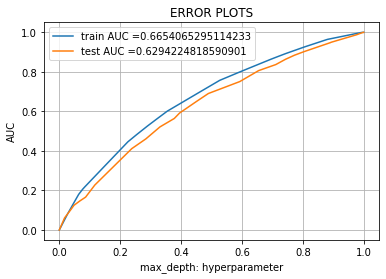

In [82]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid("whitegrid")
plt.show()

In [85]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    global test_predictions
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    test_predictions = predictions        
    return predictions

In [86]:
# Plot the confusion matrix

from sklearn.metrics import confusion_matrix

best_threshold = find_best_threshold(tr_thresholds,train_fpr,train_tpr)

print("Train Confusion Matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred,best_threshold)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred,best_threshold)))

the maximum value of tpr*(1-fpr) 0.3879374873514354 for threshold 0.863
Train Confusion Matrix
[[ 3335  1833]
 [11300 17032]]
Test Confusion Matrix
[[1540 1006]
 [5697 8257]]


Train data confusion matrix


Text(0.5, 7.5, 'Actual Values')

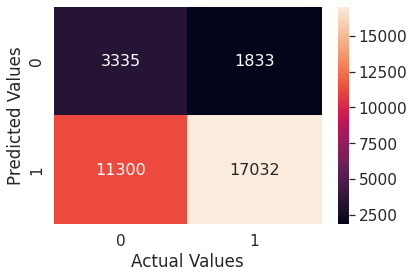

In [87]:
# Plot Confusion Matrix using heat map
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("Train data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_threshold)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')

Test data confusion matrix


Text(0.5, 7.5, 'Actual Values')

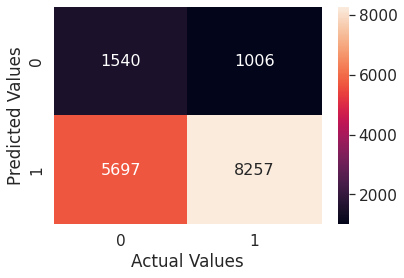

In [88]:
print("Test data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_threshold)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')

In [89]:
# Use GridSearchCV to get the best value of our hyper - parameter (alpha)
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier

model = LGBMClassifier(class_weight='balanced')

param_grid = {"max_depth":[1,5,10,50,100,500],
              "n_estimators":[50,100,150,200,300]}

clf = RandomizedSearchCV(model,param_grid,n_jobs=-1,cv=5,scoring='roc_auc',return_train_score=True,verbose=10)

clf.fit(X_set1_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 10, 50, 100, 500],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300]},
                   return_train_score=True, scoring='roc_auc', verbose=10)

In [90]:
#Output of GridSearchCV

print('Best score: ',clf.best_score_)
print('Best params: ',clf.best_params_)

Best score:  0.699098829468655
Best params:  {'n_estimators': 50, 'max_depth': 100}


In [91]:
# Get the best values for max_depth and min_samples_split

best_params = clf.best_params_

print("best value for max_depth - ",best_params['max_depth'])
print("best value for n_estimators - ",best_params['n_estimators'])

best value for max_depth -  100
best value for n_estimators -  50


In [92]:
# Apply Decision Tree Classifier on these feature sets

model_tfid_w2v = LGBMClassifier(max_depth=best_params['max_depth'],n_estimators=best_params['n_estimators'],class_weight='balanced')
model_tfid_w2v.fit(X_set1_train,y_train)

LGBMClassifier(class_weight='balanced', max_depth=100, n_estimators=50)

In [93]:
# ROC-AUC curve uses predicted probabilities. 

y_train_pred = model_tfid_w2v.predict_proba(X_set1_train)[:,1]
y_test_pred = model_tfid_w2v.predict_proba(X_set1_test)[:,1]

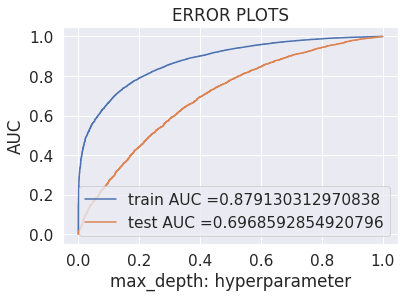

In [94]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid("whitegrid")
plt.show()

In [95]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    global test_predictions
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    test_predictions = predictions        
    return predictions

In [96]:
# Plot the confusion matrix

from sklearn.metrics import confusion_matrix

best_threshold = find_best_threshold(tr_thresholds,train_fpr,train_tpr)

print("Train Confusion Matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred,best_threshold)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred,best_threshold)))

the maximum value of tpr*(1-fpr) 0.633687514997974 for threshold 0.493
Train Confusion Matrix
[[ 4224   944]
 [ 6366 21966]]
Test Confusion Matrix
[[  742  1804]
 [ 1286 12668]]


Train data confusion matrix


Text(0.5, 7.5, 'Actual Values')

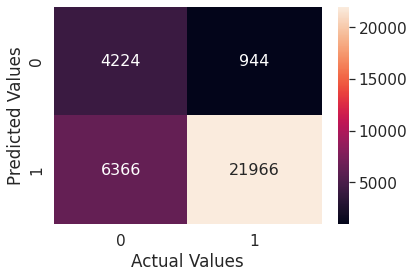

In [97]:
# Plot Confusion Matrix using heat map
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("Train data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_threshold)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')

Test data confusion matrix


Text(0.5, 7.5, 'Actual Values')

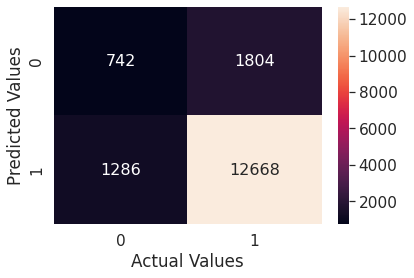

In [98]:
print("Test data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_threshold)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')